## Distinguishing stars from galaxies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from scipy.stats import mstats


### Reading Raw Data

In [2]:
raw_data = pd.read_csv('cfhtlens.csv')
cols = list(raw_data.columns)
raw_data

,id,pos,CLASS_STAR,PSF_e1,PSF_e2,scalelength,model_flux,MAG_u,MAG_g,MAG_r,MAG_i,MAG_z
0,W2p1p2_172923,134.1083747999999 -1.9783071039999953,0.290861,0.0020,0.0007,0.5355,14.4,24.6302,23.8099,23.1264,22.7502,22.4892
1,W2p1p2_172924,134.52870409999971 -1.9780708320000053,0.795745,-0.0050,-0.0138,0.7143,4.2,26.3859,25.6394,25.0811,24.2677,24.3550
2,W2p1p2_172925,134.5702499 -1.9780573680000046,0.982006,-0.0045,-0.0136,0.0000,18.1,99.0000,25.5405,24.3577,22.5565,21.8846
3,W2p1p2_172926,134.31127959999984 -1.9779969340000016,0.655828,-0.0047,-0.0086,0.8343,2.7,26.1252,25.8501,24.9644,24.5510,24.2724
4,W2p1p2_172930,134.86280589999973 -1.9779862639999892,0.911408,-0.0041,-0.0458,0.0000,17.5,24.4939,23.3056,22.9070,22.5501,22.6124
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,W2p1p3_9615,134.5917085000001 -1.8773314720000036,0.597605,0.0262,0.0042,1.2266,4.1,99.0000,26.3535,25.6606,24.0734,23.0988
4996,W2p1p3_9626,134.40929430000017 -1.877263883000017,0.453404,0.0215,-0.0055,1.2043,3.7,99.0000,25.5087,24.6339,24.3946,24.1535
4997,W2p1p3_9627,134.29153619999977 -1.8772749039999959,0.960476,-0.0052,-0.0261,0.6298,15.6,25.0978,23.8806,23.1035,22.7841,22.5671
4998,W2p1p3_9628,134.32813180000016 -1.8772201140000229,0.010498,0.0178,-0.0101,2.2392,12.7,25.4071,24.0689,23.2315,22.9067,23.1051


### Helper Methods

In [3]:
def parse_X_Y(df):
    col_headers = list(df.columns)
    df_X = df.loc[:, list(set(col_headers) - set(["CLASS_STAR", "id", "pos"]))]
    df_X = preprocessing.StandardScaler().fit(df_X).transform(df_X)
    df_Y = df.CLASS_STAR
    return df_X, df_Y

def check_if_missing_field(df,col_str):
    total_missing = len(df[df[col_str].abs() == 99]) 
    return total_missing

def drop_missing_field(df,col_str):
    dropped_set = df.drop(df[df[col_str].abs() == 99].index)
    return dropped_set

def drop_missing(raw_data):
    dropped = raw_data.copy()
    for cols in ["MAG_u","MAG_g","MAG_r","MAG_i","MAG_z"]:
        print("Missing values in ", cols)
        print(check_if_missing_field(raw_data,cols))
        dropped = drop_missing_field(dropped,cols)
    return dropped

def missing_index(df, col_str):
    dropped_ind = set(df[df[col_str].abs() == 99].index)
    return dropped_ind

def get_missing_ind(test_df):
    missing_ind = set()
    for cols in ["MAG_u","MAG_g","MAG_r","MAG_i","MAG_z"]:
        missing_ind = missing_ind.union(missing_index(test_df, cols))
    return list(missing_ind)

def impute_average_val(test_df, avg_prof):
    impute_df = test_df.copy()
    for cols in ["MAG_u","MAG_g","MAG_r","MAG_i","MAG_z"]:
        missing_i = missing_index(impute_df,cols)
        profile_mean = avg_prof[cols]
        for mis_i in missing_i:
            impute_df.loc[mis_i,cols] = profile_mean
    return impute_df

def summarize_predictions(predictions, test_Y, title_txt):
    acc = accuracy_score(test_Y, predictions)
    pred_labels = [1,0]
    disp_labels = ["star","galaxy"]
    cf_mat = confusion_matrix(y_true = test_Y, y_pred = predictions, labels = pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_mat, display_labels = disp_labels)
    disp.plot()
    plt.title(title_txt + " Accuracy: " + str(acc))
    plt.show()
    return acc


### Dataset Profile (Raw Data)

In [4]:
 # Classification Criteria
raw_data.loc[(raw_data.CLASS_STAR >= 0.5), 'CLASS_STAR'] = 1
raw_data.loc[(raw_data.CLASS_STAR < 0.5), 'CLASS_STAR'] = 0

# Dataset Profile
print(raw_data.describe())

# Missing Values
dropd = drop_missing(raw_data)

        CLASS_STAR       PSF_e1       PSF_e2  scalelength   model_flux  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.312600     0.003734    -0.011913     1.349806    16.535380   
std       0.463599     0.014620     0.019939     0.900483    36.952485   
min       0.000000    -0.023300    -0.081700     0.000000     1.600000   
25%       0.000000    -0.007600    -0.023400     0.730900     4.200000   
50%       0.000000    -0.003900    -0.009000     1.249250     6.600000   
75%       1.000000     0.017400     0.004400     1.869850    13.325000   
max       1.000000     0.061700     0.027200     5.381000   708.400000   

             MAG_u        MAG_g        MAG_r        MAG_i        MAG_z  
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000  
mean     35.334891    26.018069    24.368224    23.397327    25.460167  
std      25.557075    13.913931     5.290221     2.306313    13.292425  
min      20.011400   -99.000000    18.618

### Dataset Profile (Without Missing Values)

In [5]:
# Dataset Profile
dropd.describe()

,CLASS_STAR,PSF_e1,PSF_e2,scalelength,model_flux,MAG_u,MAG_g,MAG_r,MAG_i,MAG_z
count,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000,4176.000000
mean,0.257423,0.003426,-0.012164,1.433469,17.908118,25.081348,24.393505,23.859223,23.323700,23.060566
std,0.437267,0.014332,0.019892,0.891300,38.011256,1.001520,0.968401,1.038680,1.108981,1.197584
min,0.000000,-0.023300,-0.081700,0.000000,2.200000,20.161600,19.176000,18.841400,18.682700,18.483900
25%,0.000000,-0.007700,-0.023700,0.839525,4.500000,24.501700,23.904400,23.361325,22.758675,22.411700
50%,0.000000,-0.004000,-0.009300,1.335350,7.000000,25.096950,24.527200,24.106300,23.629850,23.334350
75%,1.000000,0.016900,0.004200,1.945500,14.625000,25.695125,25.021500,24.590575,24.173550,23.910075
max,1.000000,0.061700,0.027200,5.381000,574.200000,28.008600,27.217800,25.995100,24.661700,25.521900


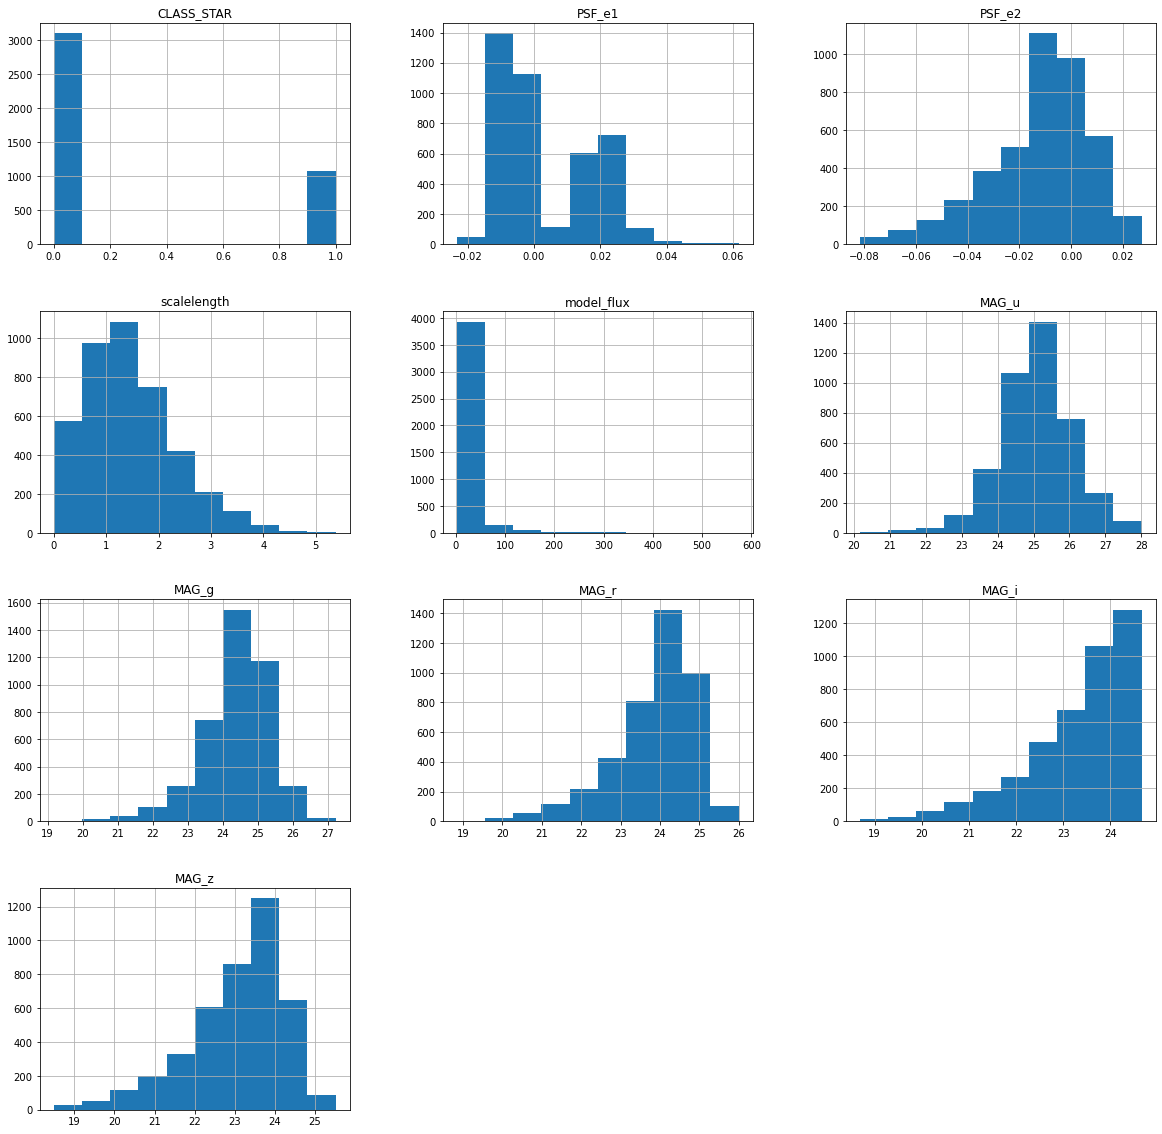

In [6]:
# Histogram for data without missing values
dropd.hist(figsize = (20,20));

In [7]:
# Dataframe of only missing values
ind_list = [i for i in range(5000)]
missing_index_list = list(set(ind_list) - set(dropd.index))
missing_df = raw_data.loc[missing_index_list, :]

### Experiment Design

In [8]:
acc_set = []
missing_acc_set = []

def experiment(seed=1):
    print("Trial Number:", seed)
    # Accuracy 
    exp_acc = []
    missing_acc = []
    
    # Splitting Raw Data For Training and Testing
    train_df = dropd.sample(n=3000, random_state=seed)
    profile_mean = train_df.select_dtypes(['number']).mean()

    test_df = raw_data.copy()

    train_X, train_Y = parse_X_Y(train_df)
    
    # Getting Test set
    for ids in train_df["id"]:
        test_df = test_df[test_df["id"] != ids]
    test_X, test_Y = parse_X_Y(test_df)

    # Training a LogisticRegression on 3000 records with no missing values
    clf = LogisticRegression(random_state=seed)
    clf.fit(train_X, train_Y)

    # Testing handling of missing values in Test Set
    predictions = clf.predict(test_X)
    acc = summarize_predictions(predictions, test_Y, "No processing")
    exp_acc.append(acc)


    # Parse dataframe of only missing values for test features and labels
    test_missing_X, test_missing_Y = parse_X_Y(missing_df)
    predictions = clf.predict(test_missing_X)
    acc = summarize_predictions(predictions, test_missing_Y, "No processing: Missing")
    missing_acc.append(acc)


    # A. Omit missing values

    print("A. Omit missing values")

    # Dropping Missing Values
    clean_test_df = drop_missing(test_df)
    test_clean_X, test_clean_Y = parse_X_Y(clean_test_df)
    predictions_clean = clf.predict(test_clean_X)

    # Missclassified Missing Values
    append_len = (len(test_Y) - len(predictions_clean))

    # Abstaining 
    abstain_list = (list(predictions_clean)) + list(1 - test_Y[-append_len:])
    acc = summarize_predictions(abstain_list, test_Y, "Abstain")
    exp_acc.append(acc)

    test_missing_X, test_missing_Y = parse_X_Y(missing_df)

    # Getting Accuracy
    predictions = 1 - test_missing_Y
    acc = summarize_predictions(predictions, test_missing_Y, "Abstain: Missing")
    missing_acc.append(acc)

    # B. Predict majority class
    print("B. Predict majority class")

    # Majority Class Label 
    maj_cls = np.argmax(train_df['CLASS_STAR'].value_counts())

    # Predict for all samples with missing values
    mis_ind = np.unique(get_missing_ind(test_df.reset_index()))
    predictions = clf.predict(test_X)

    predictions[mis_ind] = maj_cls
    acc = summarize_predictions(predictions, test_Y, "Majority")
    exp_acc.append(acc)

    # Predict for samples with only missing values
    predictions = [maj_cls]*len(missing_df)
    acc = summarize_predictions(predictions, test_missing_Y, "Majority: Missing")
    missing_acc.append(acc)

    # C. Omit features with missing values
    print("C. Omit features with missing values")
    train_omit_df = train_df.copy()
    test_omit_df = test_df.copy()
    missing_omit_df = missing_df.copy()

    # Dropping features with missing values
    for cols in ["MAG_u","MAG_g","MAG_r","MAG_i","MAG_z"]:
        train_omit_df = train_omit_df.drop(columns = cols)
        test_omit_df = test_omit_df.drop(columns = cols)
        missing_omit_df = missing_omit_df.drop(columns = cols)
    train_omit_X, train_omit_Y = parse_X_Y(train_omit_df)
    test_omit_X, test_omit_Y = parse_X_Y(test_omit_df)

    # New classifier without missing values
    clf_omit = LogisticRegression(random_state=seed)
    clf_omit.fit(train_omit_X, train_omit_Y)

    # Predicting  without missing values
    predictions = clf_omit.predict(test_omit_X)
    acc = summarize_predictions(predictions, test_omit_Y, "Omit features")
    exp_acc.append(acc)

    # Test on the missing value set 
    test_missing_X, test_missing_Y = parse_X_Y(missing_omit_df)
    predictions = clf_omit.predict(test_missing_X)
    acc = summarize_predictions(predictions, test_missing_Y, "Omit features: Missing")
    missing_acc.append(acc)

    # D. Impute Average Value
    print("D. Impute Average Value")

    # Using mean to impute missing values for test data
    imputed_test_df = impute_average_val(test_df, profile_mean)
    test_impute_X, test_impute_Y = parse_X_Y(imputed_test_df)
    predictions = clf.predict(test_impute_X)
    acc = summarize_predictions(predictions, test_impute_Y, "Impute Average")
    exp_acc.append(acc)

    # Using mean to impute missing values in set of only missing samples
    imputed_missing_df = impute_average_val(missing_df, profile_mean)
    test_missing_X, test_missing_Y = parse_X_Y(imputed_missing_df)
    predictions = clf.predict(test_missing_X)
    acc = summarize_predictions(predictions, test_missing_Y, "Impute Average: Missing")
    missing_acc.append(acc)

    # E. My Methohd: Winsorize
    print("E. My Methohd: Winsorize")
    test_df_wins = test_df.copy()
    missing_df_wins = missing_df.copy()
    for cols in ["MAG_u","MAG_g","MAG_r","MAG_i","MAG_z"]:
        window = [0.2, 0.2]
        if cols == "Mag_u":
            wins_window = [0, 0.9]
        test_df_wins.loc[:, cols] =  mstats.winsorize(test_df.loc[:, cols], limits=window)
        missing_df_wins.loc[:,cols] =  mstats.winsorize(missing_df_wins.loc[:, cols], limits=window)
    test_wins_X, test_wins_Y = parse_X_Y(test_df_wins)
    predictions = clf.predict(test_wins_X)
    acc = summarize_predictions(predictions, test_wins_Y, "Winsorize")
    exp_acc.append(acc)
    test_wins_missing_X, test_wins_missing_Y = parse_X_Y(missing_df_wins)
    predictions = clf.predict(test_wins_missing_X)
    acc = summarize_predictions(predictions, test_wins_missing_Y, "Winsorize: Missing")
    missing_acc.append(acc)
    
    
    # Aggregating accuracy
    acc_set.append(exp_acc)
    missing_acc_set.append(missing_acc)

### Repeating the Experiment 10 times

Trial Number: 0


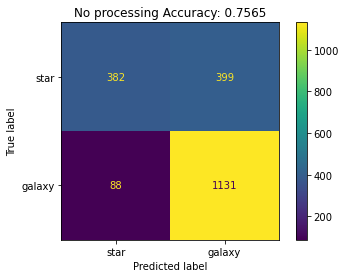

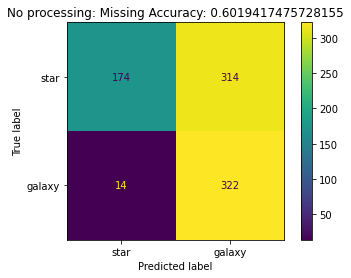

A. Omit missing values
Missing values in  MAG_u
693
Missing values in  MAG_g
144
Missing values in  MAG_r
24
Missing values in  MAG_i
2
Missing values in  MAG_z
157


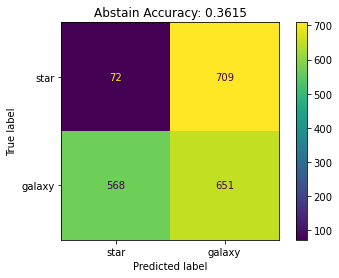

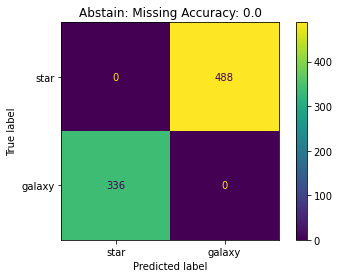

B. Predict majority class


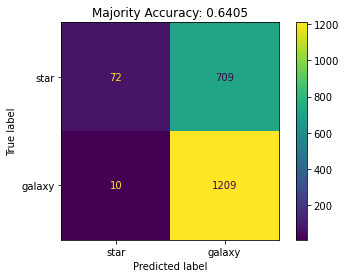

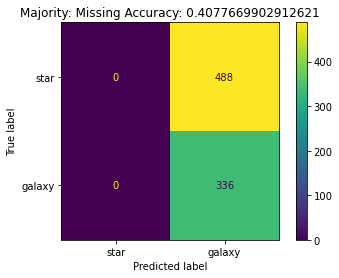

C. Omit features with missing values


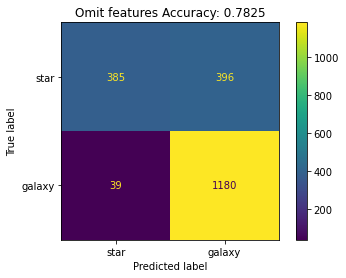

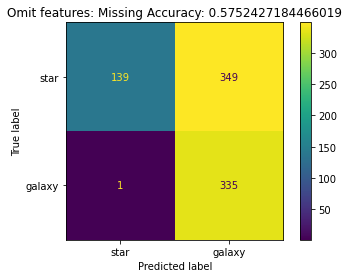

D. Impute Average Value


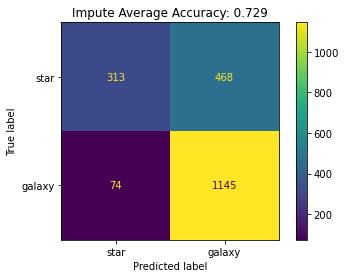

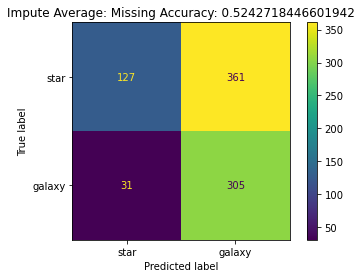

E. My Methohd: Winsorize


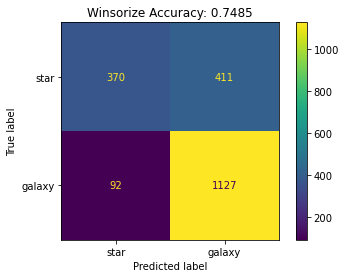

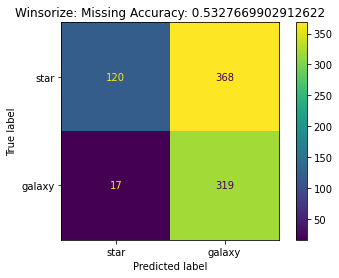

Trial Number: 1


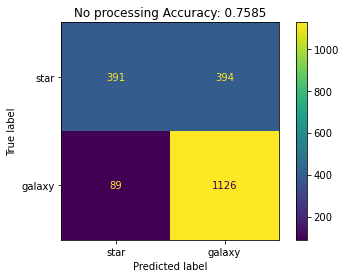

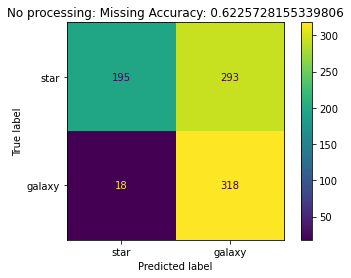

A. Omit missing values
Missing values in  MAG_u
693
Missing values in  MAG_g
144
Missing values in  MAG_r
24
Missing values in  MAG_i
2
Missing values in  MAG_z
157


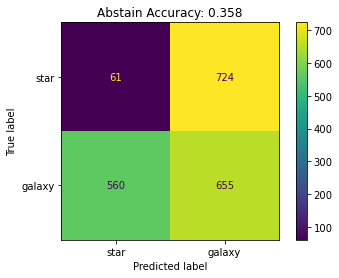

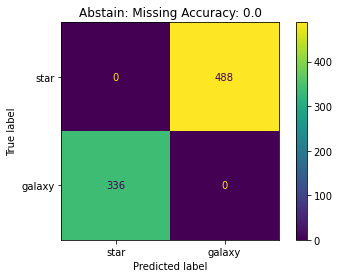

B. Predict majority class


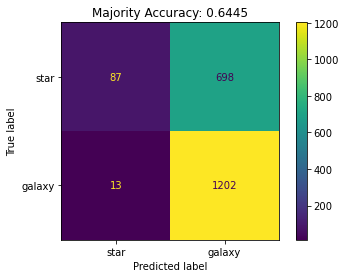

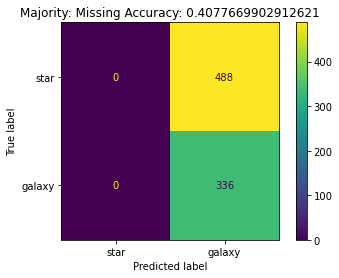

C. Omit features with missing values


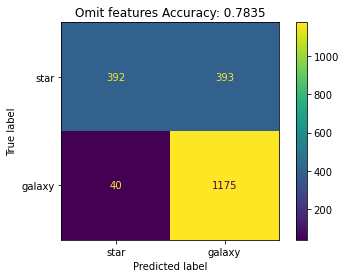

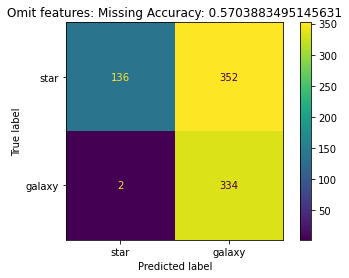

D. Impute Average Value


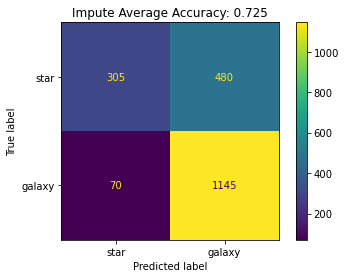

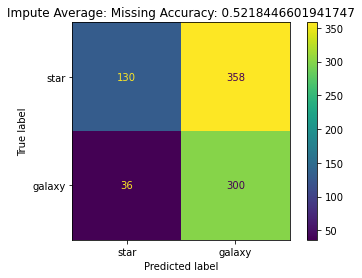

E. My Methohd: Winsorize


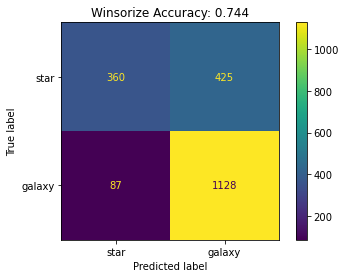

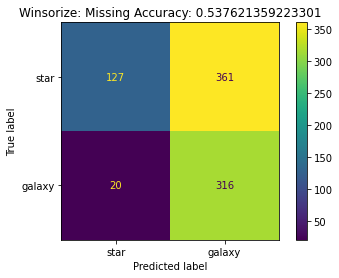

Trial Number: 2


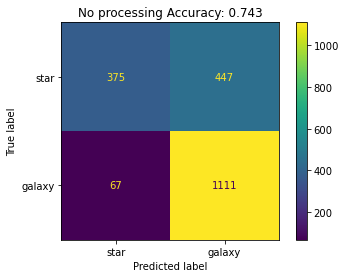

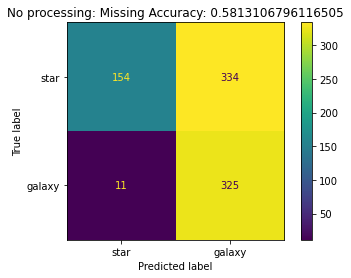

A. Omit missing values
Missing values in  MAG_u
693
Missing values in  MAG_g
144
Missing values in  MAG_r
24
Missing values in  MAG_i
2
Missing values in  MAG_z
157


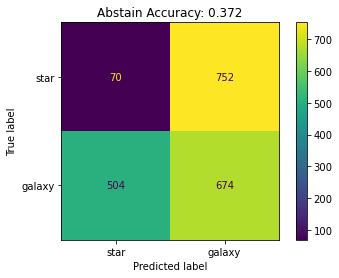

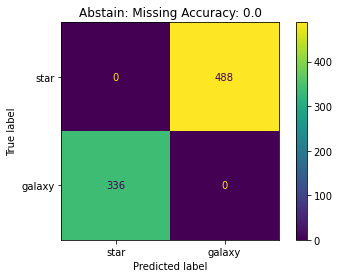

B. Predict majority class


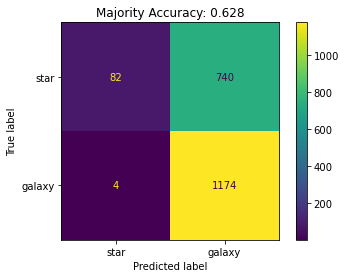

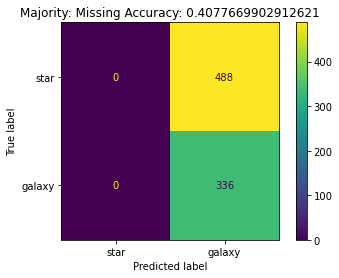

C. Omit features with missing values


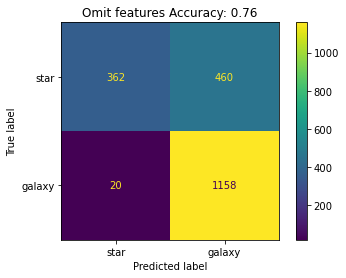

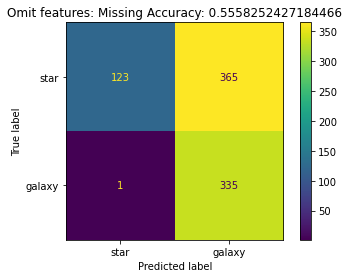

D. Impute Average Value


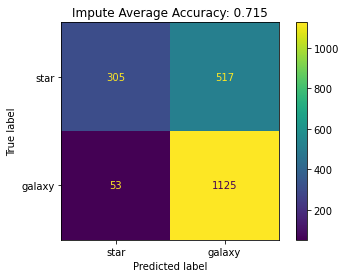

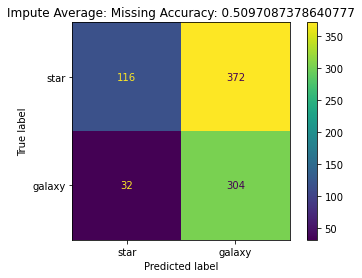

E. My Methohd: Winsorize


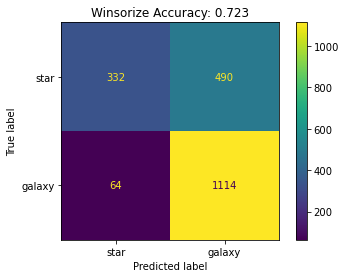

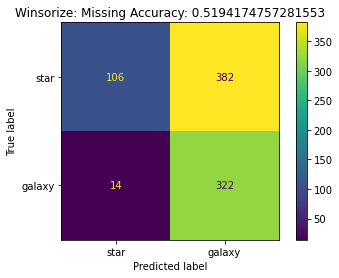

Trial Number: 3


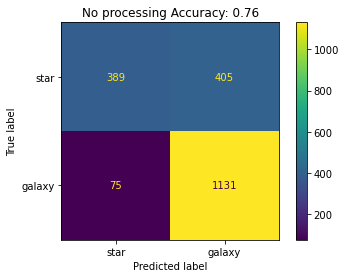

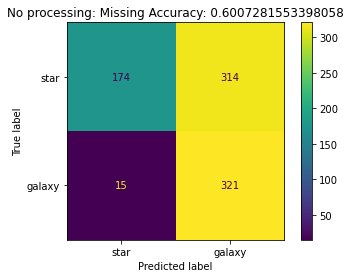

A. Omit missing values
Missing values in  MAG_u
693
Missing values in  MAG_g
144
Missing values in  MAG_r
24
Missing values in  MAG_i
2
Missing values in  MAG_z
157


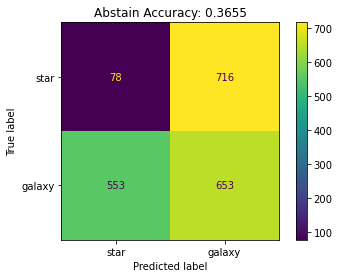

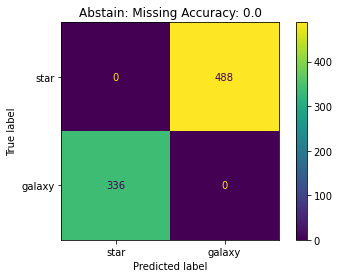

B. Predict majority class


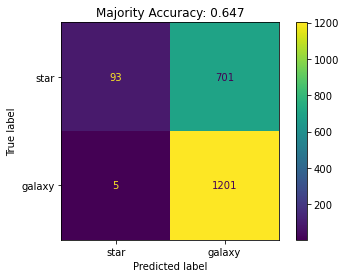

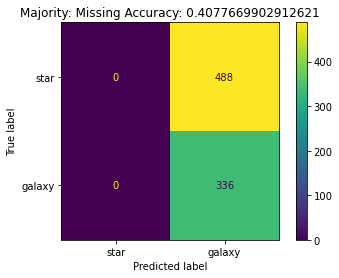

C. Omit features with missing values


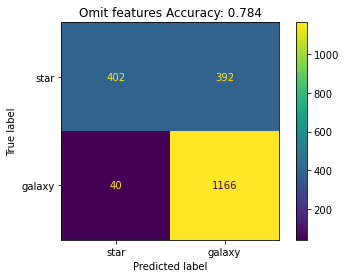

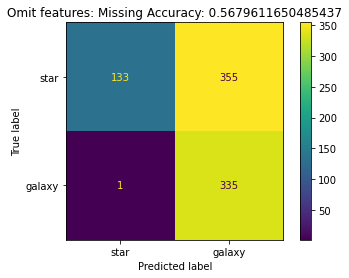

D. Impute Average Value


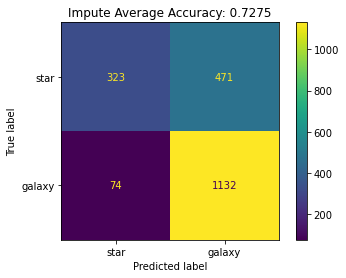

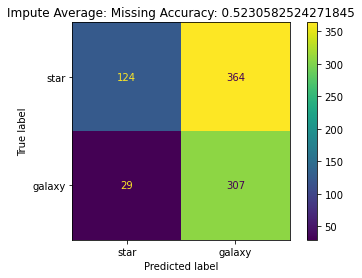

E. My Methohd: Winsorize


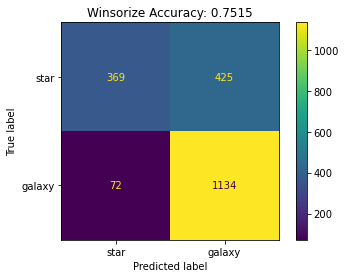

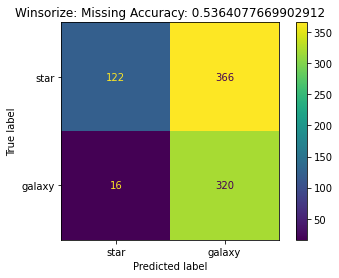

Trial Number: 4


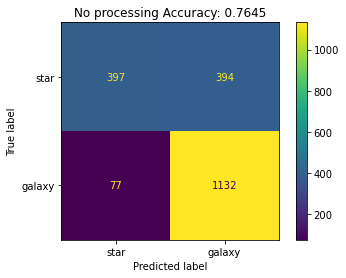

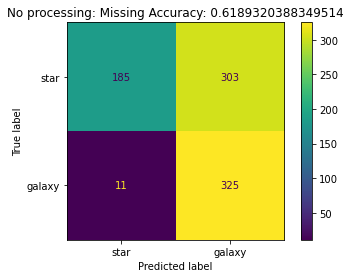

A. Omit missing values
Missing values in  MAG_u
693
Missing values in  MAG_g
144
Missing values in  MAG_r
24
Missing values in  MAG_i
2
Missing values in  MAG_z
157


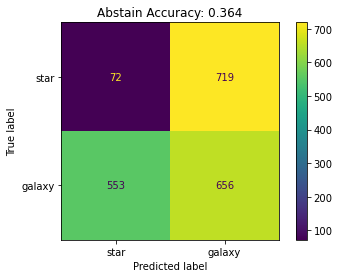

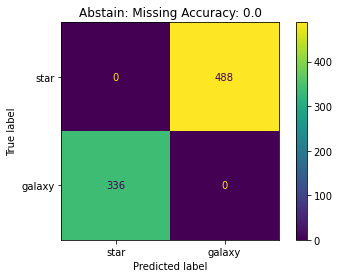

B. Predict majority class


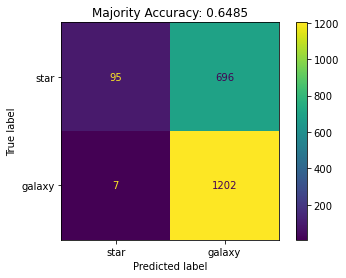

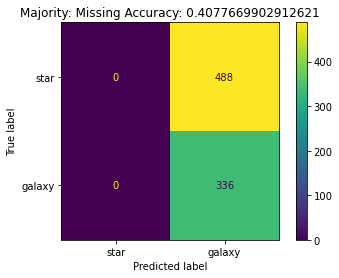

C. Omit features with missing values


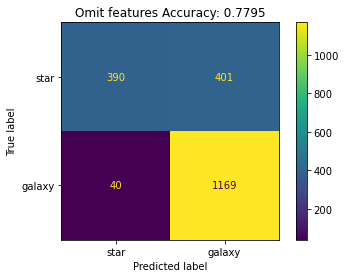

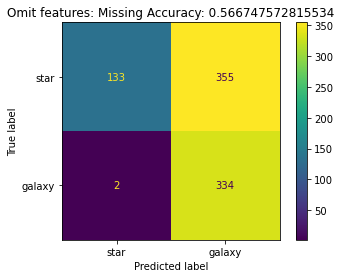

D. Impute Average Value


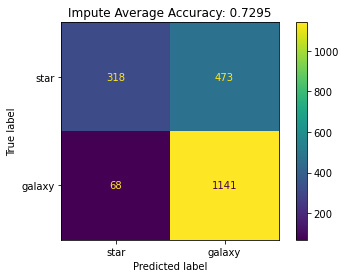

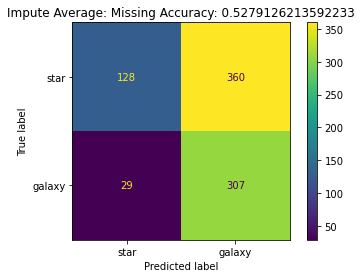

E. My Methohd: Winsorize


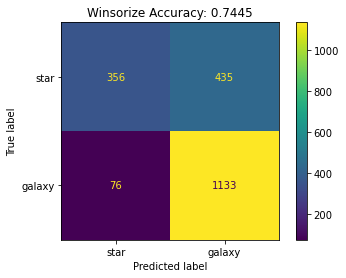

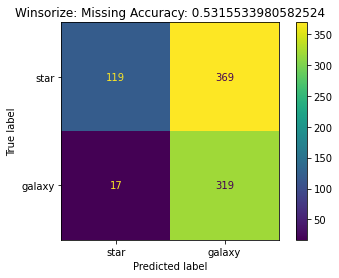

Trial Number: 5


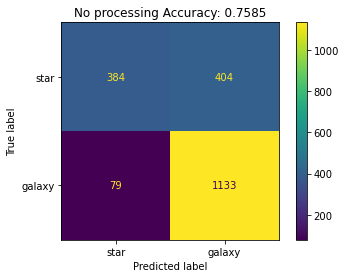

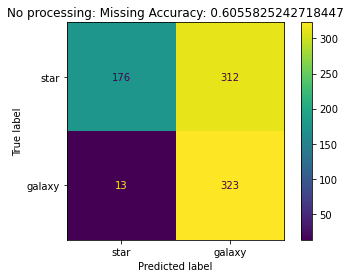

A. Omit missing values
Missing values in  MAG_u
693
Missing values in  MAG_g
144
Missing values in  MAG_r
24
Missing values in  MAG_i
2
Missing values in  MAG_z
157


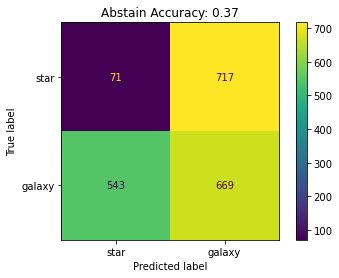

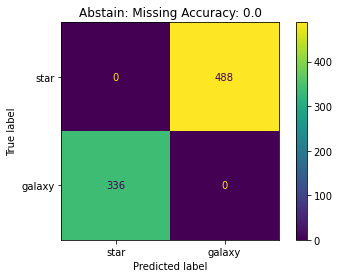

B. Predict majority class


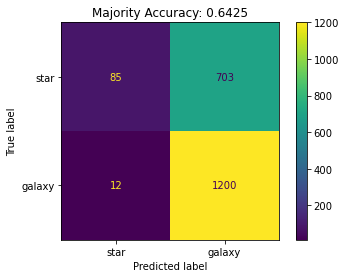

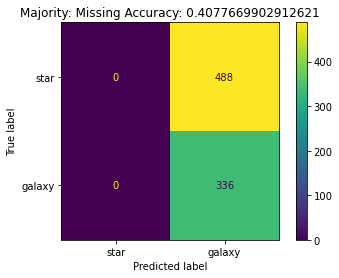

C. Omit features with missing values


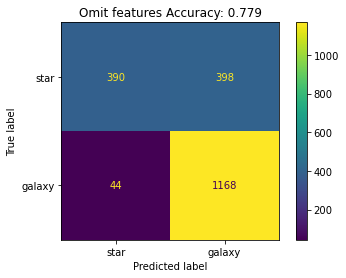

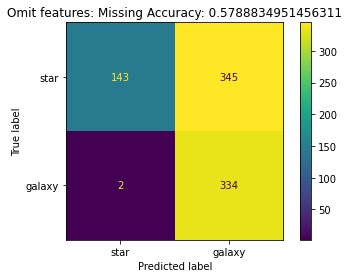

D. Impute Average Value


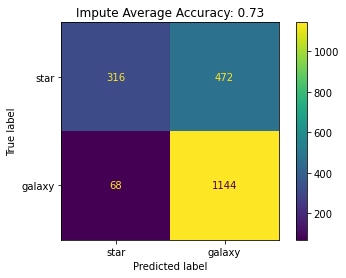

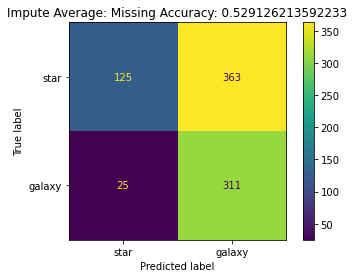

E. My Methohd: Winsorize


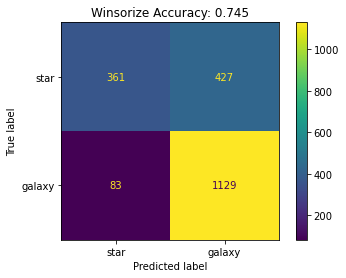

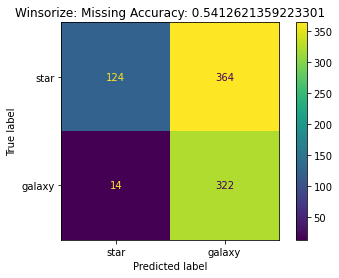

Trial Number: 6


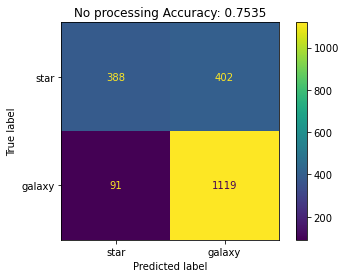

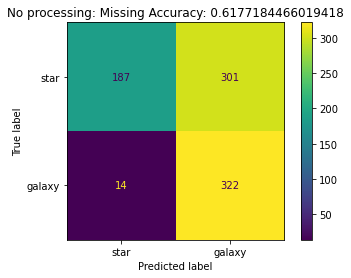

A. Omit missing values
Missing values in  MAG_u
693
Missing values in  MAG_g
144
Missing values in  MAG_r
24
Missing values in  MAG_i
2
Missing values in  MAG_z
157


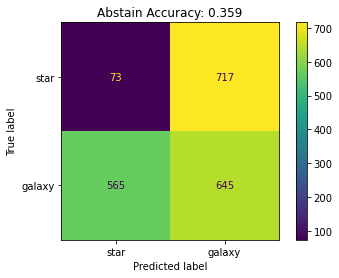

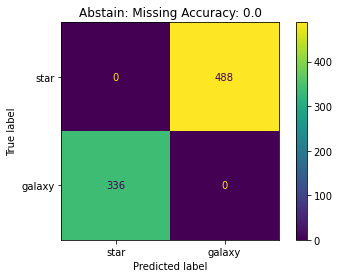

B. Predict majority class


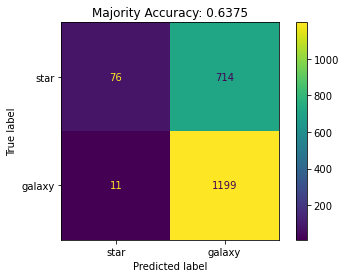

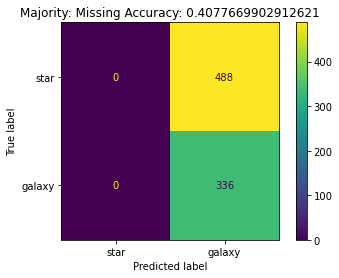

C. Omit features with missing values


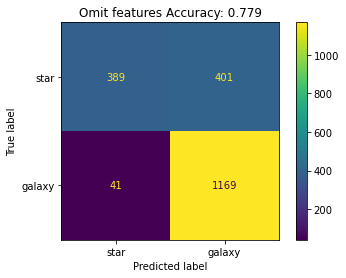

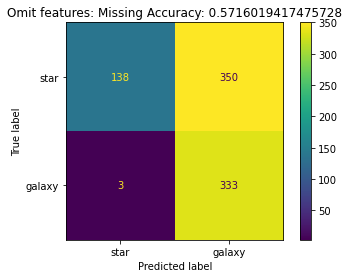

D. Impute Average Value


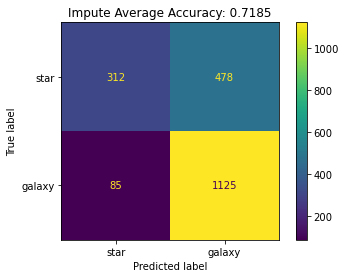

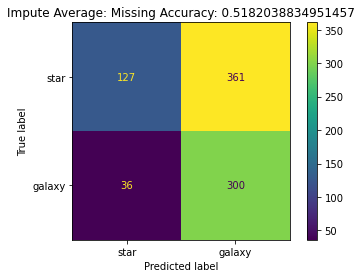

E. My Methohd: Winsorize


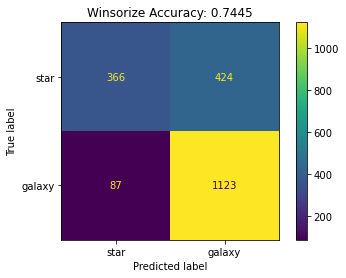

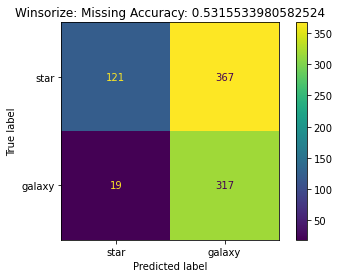

Trial Number: 7


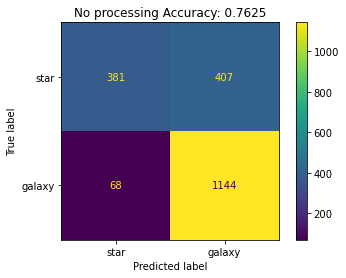

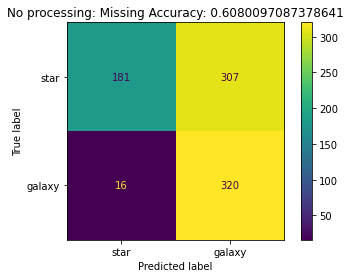

A. Omit missing values
Missing values in  MAG_u
693
Missing values in  MAG_g
144
Missing values in  MAG_r
24
Missing values in  MAG_i
2
Missing values in  MAG_z
157


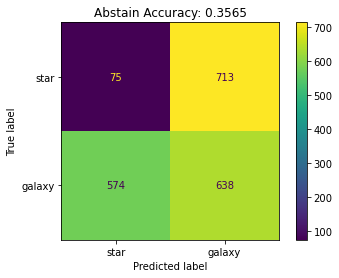

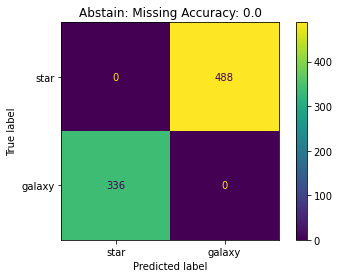

B. Predict majority class


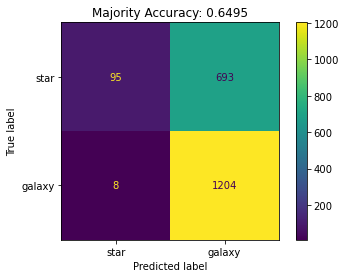

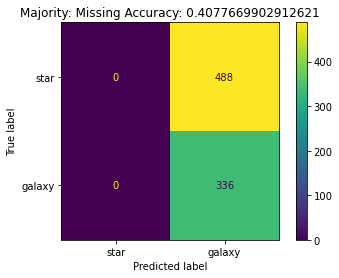

C. Omit features with missing values


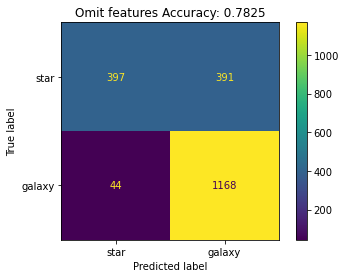

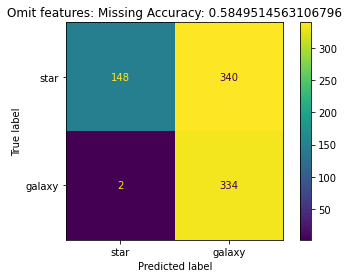

D. Impute Average Value


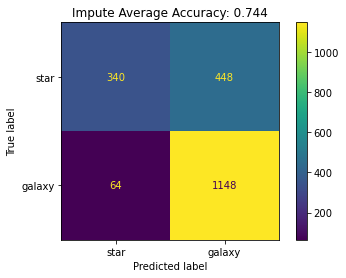

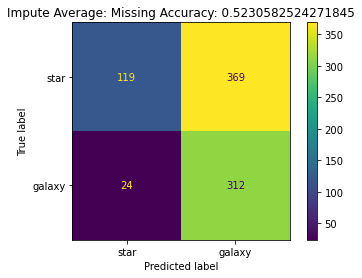

E. My Methohd: Winsorize


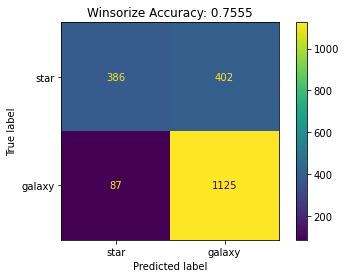

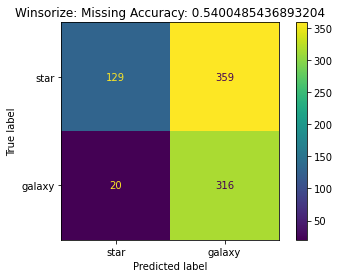

Trial Number: 8


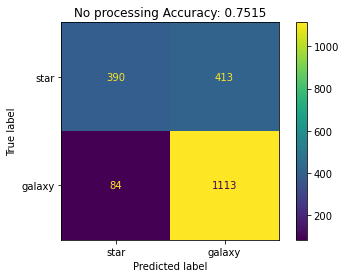

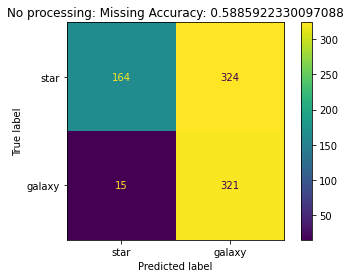

A. Omit missing values
Missing values in  MAG_u
693
Missing values in  MAG_g
144
Missing values in  MAG_r
24
Missing values in  MAG_i
2
Missing values in  MAG_z
157


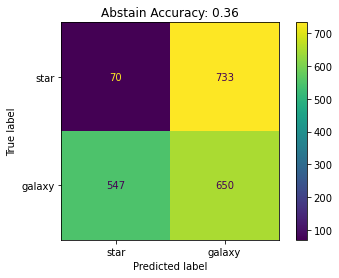

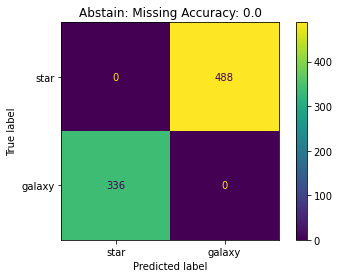

B. Predict majority class


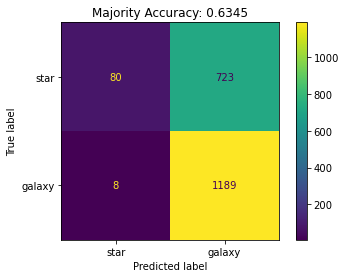

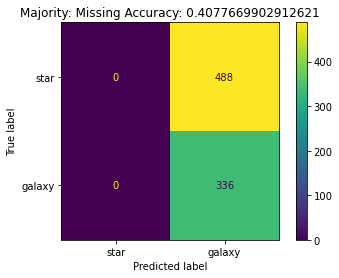

C. Omit features with missing values


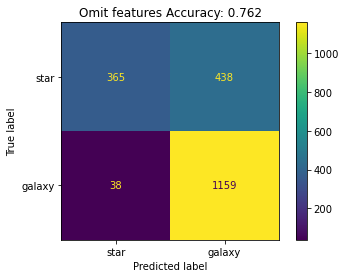

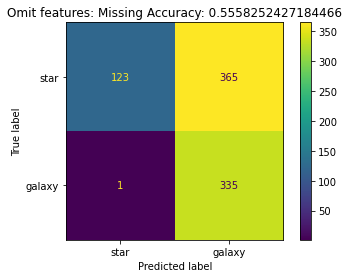

D. Impute Average Value


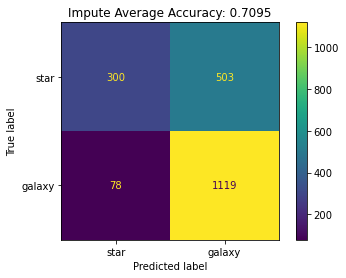

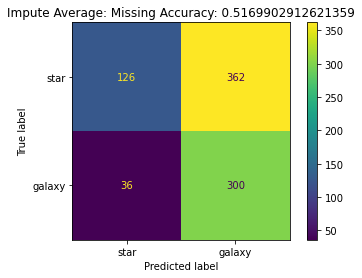

E. My Methohd: Winsorize


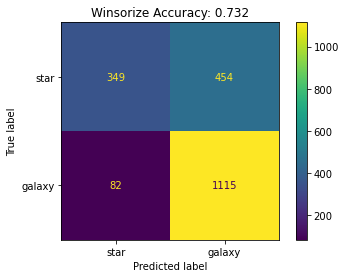

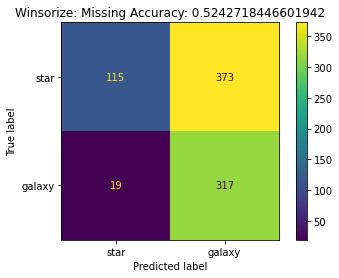

Trial Number: 9


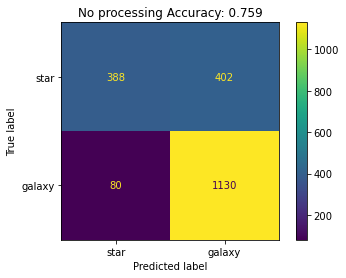

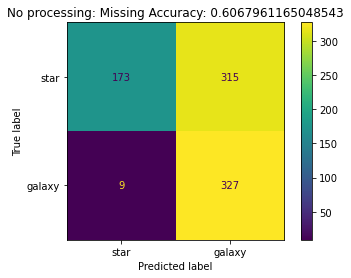

A. Omit missing values
Missing values in  MAG_u
693
Missing values in  MAG_g
144
Missing values in  MAG_r
24
Missing values in  MAG_i
2
Missing values in  MAG_z
157


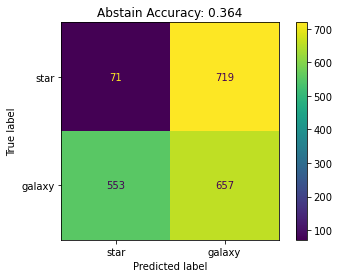

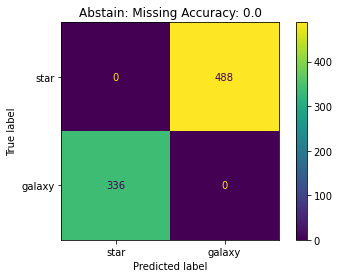

B. Predict majority class


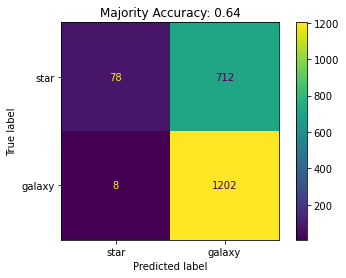

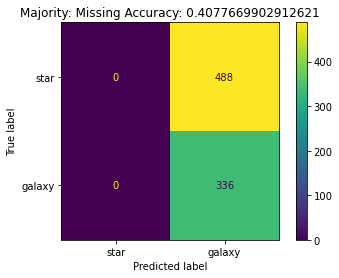

C. Omit features with missing values


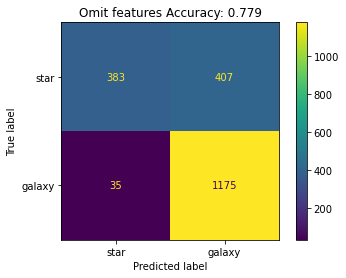

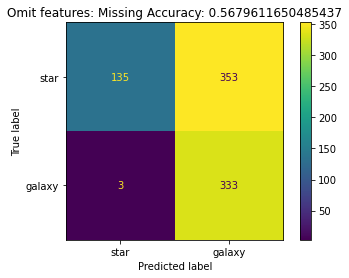

D. Impute Average Value


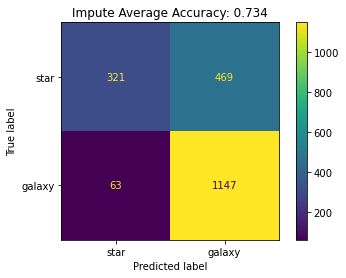

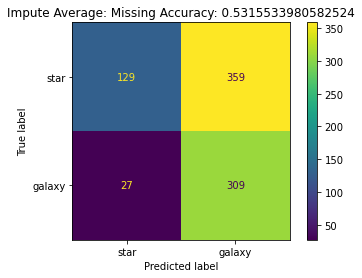

E. My Methohd: Winsorize


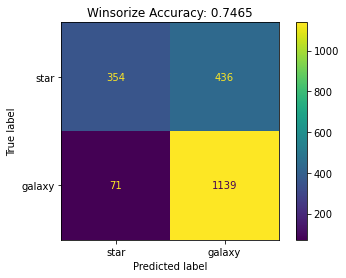

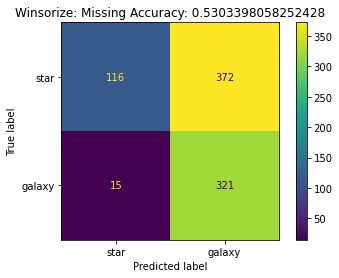

In [9]:
num_trials = 10
for i in range(num_trials):
    experiment(i)

### Average across 10 trials

In [10]:
# Average predictions on Complete Set
print("Complete Set", np.mean(acc_set, axis=0))
# Average prediction on Only Missing Values
print("Only Missing Values", np.mean(missing_acc_set, axis=0))

Complete Set [0.75675 0.36305 0.64125 0.7771  0.7262  0.7435 ]
Only Missing Values [0.60521845 0.         0.40776699 0.56953883 0.52257282 0.53252427]


### Predicting my sky object

In [11]:
# Predict on my sky object
my_sky_obj = pd.read_csv('myskyobj.csv')
my_sky_obj.loc[(my_sky_obj.CLASS_STAR >= 0.5), 'CLASS_STAR'] = 1
my_sky_obj.loc[(my_sky_obj.CLASS_STAR < 0.5), 'CLASS_STAR'] = 0
test_my_sky_X, test_my_sky_Y = parse_X_Y(my_sky_obj)

# Splitting Raw Data For Training and Testing
train_df = dropd.sample(n=3000, random_state=0)
test_df = raw_data.copy()
train_X, train_Y = parse_X_Y(train_df)
# Getting Test set
for ids in train_df["id"]:
    test_df = test_df[test_df["id"] != ids]
test_X, test_Y = parse_X_Y(test_df)

clf_my_obj = LogisticRegression(random_state=0)
clf_my_obj.fit(train_X, train_Y)
pred = clf_my_obj.predict(test_my_sky_X)
print("Predicted: ",pred)
print("Actual Data",test_my_sky_Y[0])

Predicted:  [0.]
Actual Data 1.0
